In [345]:
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.gridspec as gridspec
import time
from torch.autograd import Variable


np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the ODE

$$\frac{du}{dt} - cos(2\pi t)=0$$

with solution 
$$ u(t) = \frac{sin ( 2 \pi t )}{2 \pi} + 1$$

## The Inverse parametric equation will be 

$$\frac{du}{dt} - cos( \alpha \pi t)=0$$

Text(0, 0.5, 'Observations')

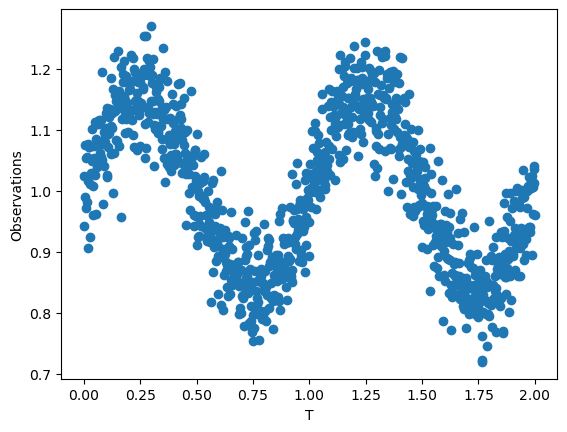

In [346]:
t= np.linspace(0,2,1000)
mean, std = 0,0.05

Exact = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [347]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## PINN for Inverse Problems

In [348]:
def register_parameters(self,alpha):
    self.alpha = torch.nn.Parameter(torch.tensor(alpha, requires_grad=True).float().to(device))
    self.register_parameter("alpha", self.alpha)

def net_f(self,t):
    """ The pytorch autograd version of calculating residual """
    u = self(t)
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = u_t - self.alpha*torch.cos( 2*torch.pi *t)
    return f

In [349]:
DNN.register_parameters = register_parameters
DNN.PINN = net_f

In [350]:
def train(pinn, loss, optimizer,data_loader,epochs):
  pinn.train()

  print("Starting Training")

  for epoch in range(epochs):
    itr_loss = 0.0   

    for _,(X,y) in enumerate(data_loader):
      iter = 0


      X, y = Variable(X, requires_grad=True), Variable(y)

      def loss_func_train():

        optimizer.zero_grad()

        u_pred,f_pred = pinn(X),pinn.PINN(X)

        loss_u,loss_f = loss(u_pred,y),loss(f_pred,torch.zeros_like(y))

        Loss = loss_u + loss_f

        Loss.backward() 

        if iter % 100 == 0:
          print(
              'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e, Alpha:%.3f' % (iter, Loss.item(), loss_u.item(), loss_f.item(),pinn.alpha.item())
                )
        return Loss

      optimizer.step(loss_func_train) 
      iter += 1
     
      oupt = pinn(X)  

      loss_val = loss_func_train() 

      itr_loss += loss_val.item()  

    print("iteration = %4d   loss = %0.4f" % (epoch, itr_loss))


In [351]:
# Number of observations
nobs = 500
lr = 0.1
epochs = 10

layers = [1]+2*[10] +[1]

data_training = np.hstack((t.flatten()[:,None], noise_sol.flatten()[:,None]))

idx = np.random.choice(data_training.shape[0], nobs, replace=False)

X_u_train = torch.from_numpy(data_training[idx, :]).float().to(device)

x,y = X_u_train[:,0:1].reshape(-1,1),X_u_train[:,1:2].reshape(-1,1)

X_u_train = TensorDataset(x,y)
X_u_train = DataLoader(X_u_train,batch_size=100)

In [352]:
model = DNN(layers)
model.register_parameters(0.5)

In [353]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

In [354]:
train(model, loss, optimizer,X_u_train,epochs)

Starting Training
Iter 0, Loss: 1.49468e+00, Loss_u: 1.35293e+00, Loss_f: 1.41750e-01, Alpha:0.500
Iter 0, Loss: 1.43915e+00, Loss_u: 1.29673e+00, Loss_f: 1.42419e-01, Alpha:0.498
Iter 0, Loss: 9.98593e-01, Loss_u: 8.46935e-01, Loss_f: 1.51657e-01, Alpha:0.479
Iter 0, Loss: 8.25412e-01, Loss_u: 6.75426e-01, Loss_f: 1.49986e-01, Alpha:0.465
Iter 0, Loss: 1.90726e-01, Loss_u: 4.00708e-02, Loss_f: 1.50655e-01, Alpha:0.364
Iter 0, Loss: 1.78839e-01, Loss_u: 3.77933e-02, Loss_f: 1.41046e-01, Alpha:0.358
Iter 0, Loss: 9.76877e-02, Loss_u: 2.26346e-02, Loss_f: 7.50531e-02, Alpha:0.297
Iter 0, Loss: 8.82370e-02, Loss_u: 2.13785e-02, Loss_f: 6.68586e-02, Alpha:0.281
Iter 0, Loss: 3.88940e-02, Loss_u: 1.56014e-02, Loss_f: 2.32926e-02, Alpha:0.139
Iter 0, Loss: 3.71346e-02, Loss_u: 1.55637e-02, Loss_f: 2.15709e-02, Alpha:0.129
Iter 0, Loss: 2.62617e-02, Loss_u: 1.53831e-02, Loss_f: 1.08786e-02, Alpha:0.040
Iter 0, Loss: 2.54084e-02, Loss_u: 1.53388e-02, Loss_f: 1.00696e-02, Alpha:0.034
Iter 0, Lo

In [355]:
from laplace import Laplace

la = Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='diag')
        
la.fit(X_u_train)

In [356]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)

hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

for i in range(1000):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [369]:
torch.nn.utils.parameters_to_vector(la.model.last_layer.parameters())

tensor([-0.7059, -2.4982, -0.9594, -0.1146,  0.0251,  2.1030, -1.9623,  1.7441,
        -1.0081, -2.8880,  0.6727], grad_fn=<CatBackward0>)

In [357]:
la.mean

tensor([-0.7059, -2.4982, -0.9594, -0.1146,  0.0251,  2.1030, -1.9623,  1.7441,
        -1.0081, -2.8880,  0.6727])

In [358]:
la.posterior_precision

tensor([ 56420.3633,  69839.2734, 140570.7188, 122677.5234,  82700.5312,
         73258.7500, 165507.2500, 120467.1484,  48429.8633, 149064.8125,
        210634.7656], grad_fn=<AddBackward0>)

In [359]:
t= np.linspace(0,3,500)

sol = (1/ (2*np.pi))*np.sin(2*np.pi*t)+1

noise_sol_test = sol + np.random.normal(mean,std, len(t))

In [360]:
f_mu, f_var = la(torch.tensor(t.flatten()[:,None]).float())
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)


In [361]:

u_pred = model(torch.tensor(t.flatten()[:,None] ).float()).detach().cpu().numpy()

error_u = np.linalg.norm(noise_sol_test-u_pred,2)/np.linalg.norm(noise_sol_test,2)
print('Error u: %e' % (error_u)) 

Error u: 4.452806e+00


In [372]:
for name, param in la.model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

model.alpha tensor(1.0138)
model.layers.layer_0.weight tensor([[-1.0105],
        [ 2.7615],
        [ 1.1261],
        [ 0.4192],
        [ 0.0192],
        [ 0.6123],
        [-1.6072],
        [-0.1881],
        [-0.2870],
        [-1.3022]])
model.layers.layer_0.bias tensor([ 1.0380, -4.2769,  0.3939,  0.0655,  0.2720, -0.3347, -0.0772,  0.6078,
         0.5458,  1.7729])
model.layers.layer_1.weight tensor([[-0.7868,  0.3798,  0.3469,  0.1301,  0.1092,  0.1941, -0.1564, -0.3026,
         -0.0359,  0.3609],
        [ 0.5008,  0.4908, -0.2338, -0.3959, -0.2985, -0.2117, -0.3253,  0.8422,
          0.0477,  0.9481],
        [-0.4600,  1.2808,  0.5851, -0.4679, -0.4636, -0.1267,  0.3616,  0.1912,
         -0.7446,  1.9148],
        [-0.3567,  0.1268,  0.4701,  0.3625,  0.3940,  0.1002, -0.1721, -0.0918,
          0.0835,  0.0717],
        [ 0.1796,  0.8730, -0.0700,  0.0513, -0.1999, -0.4340,  0.3766,  0.6428,
         -0.6711,  1.2902],
        [ 0.6468, -0.1598, -0.1514, -0.5997, -0.

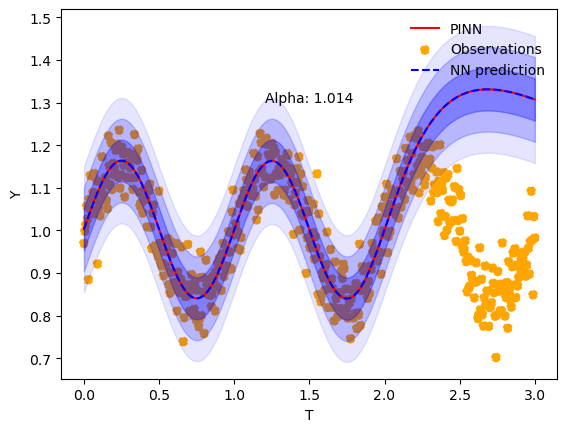

In [365]:
plt.plot(t, u_pred, label = "PINN", color = "red")


plt.scatter(t,noise_sol_test,linestyle='dashed', label = "Observations",color= "orange")
plt.annotate(f"Alpha: {model.alpha.item():0.3f}",(1.5,1.3),ha='center')


plt.plot(t, f_mu, "--",label='NN prediction',color="blue")
plt.fill_between(t, f_mu+pred_std,f_mu-pred_std,alpha=0.3, color = "blue")
plt.fill_between(t, f_mu+2*pred_std,f_mu-2*pred_std,alpha=0.2, color = "blue")
plt.fill_between(t, f_mu+3*pred_std,f_mu-3*pred_std,alpha=0.1, color = "blue")


plt.xlabel("T")
plt.ylabel("Y")
plt.legend(frameon=False)